In [1]:
import telegram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import pandahouse

In [2]:
token = '7044101108:AAETY0C2dU2iAJAV-N7y497ztoXxCBloq2E'
bot = telegram.Bot(token=token) # получаем доступ

In [3]:
chat_id = 1027001565

In [4]:
connection = { 
    'host' : 'https://clickhouse.lab.karpov.courses', 
    'password' : 'dpo_python_2020', 
    'user' : 'student', 
    'database' : 'simulator'
}

In [5]:
query = '''
    SELECT toDate(time) AS event_date,
           country,
           count(DISTINCT user_id) AS unique_users
    FROM simulator_20240620.feed_actions
    GROUP BY toDate(time), country
'''

event_df = pandahouse.read_clickhouse(connection=connection, query=query)

In [6]:
event_df

,event_date,country,unique_users
0,2024-05-29,Turkey,143
1,2024-05-21,Finland,94
2,2024-07-13,Latvia,18
3,2024-06-11,Ukraine,792
4,2024-05-13,Latvia,7
...,...,...,...
1040,2024-06-18,Ukraine,821
1041,2024-07-28,Finland,200
1042,2024-05-06,Latvia,4
1043,2024-06-23,Turkey,170


In [7]:
def transform_event_df(event_df, resample_value):
    return event_df.set_index('event_date', inplace=False).resample(resample_value).sum().reset_index()

In [8]:
wau_df = transform_event_df(event_df, 'W')
mau_df = transform_event_df(event_df, 'MS')

In [10]:
mau_df

,event_date,unique_users
0,2024-05-01,238126
1,2024-06-01,479597
2,2024-07-01,590804
3,2024-08-01,102029


<AxesSubplot:title={'center':'DAU'}, xlabel='event_date', ylabel='unique_users'>

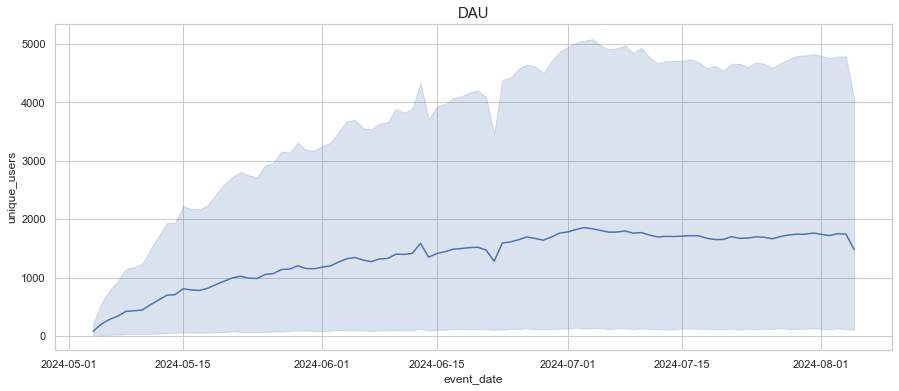

In [16]:
# daily active users 
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.title('DAU', fontsize=15)  
sns.lineplot(data=event_df, x='event_date', y='unique_users')

<AxesSubplot:title={'center':'MAU'}, xlabel='event_date', ylabel='unique_users'>

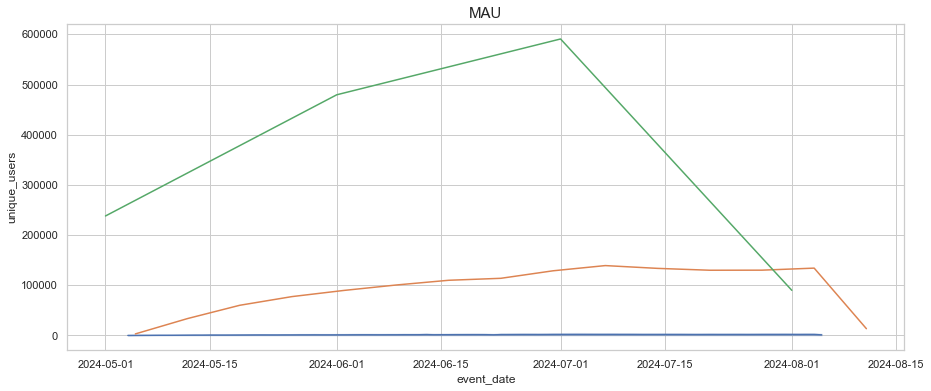

In [18]:
# weekly active users 
wau_df = event_df.set_index('event_date', inplace=False).resample('W').sum().reset_index()

In [13]:
msg = 'Отчет по работе приложения'
bot.sendMessage(chat_id = chat_id, text = msg)

<AxesSubplot:title={'center':'WAU'}, xlabel='event_date', ylabel='unique_users'>

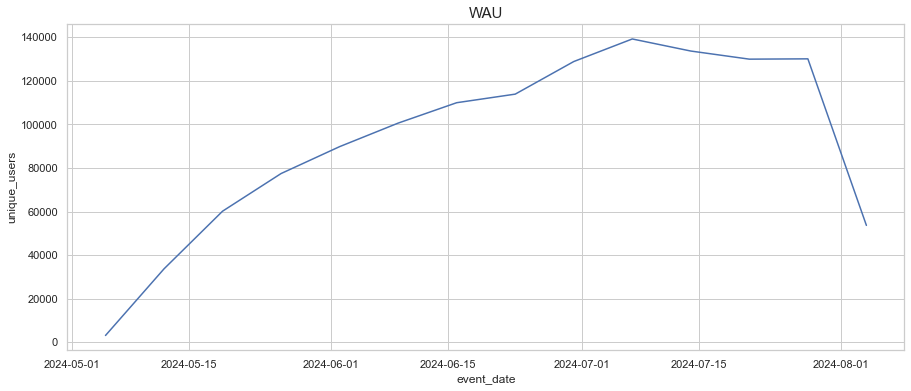

In [20]:
# daily active users 
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.title('WAU', fontsize=15)  
sns.lineplot(data=wau_df, x='event_date', y='unique_users')


In [22]:
mau_df = event_df.set_index('event_date', inplace=False).resample('MS').sum().reset_index()

<AxesSubplot:title={'center':'MAU'}, xlabel='event_date', ylabel='unique_users'>

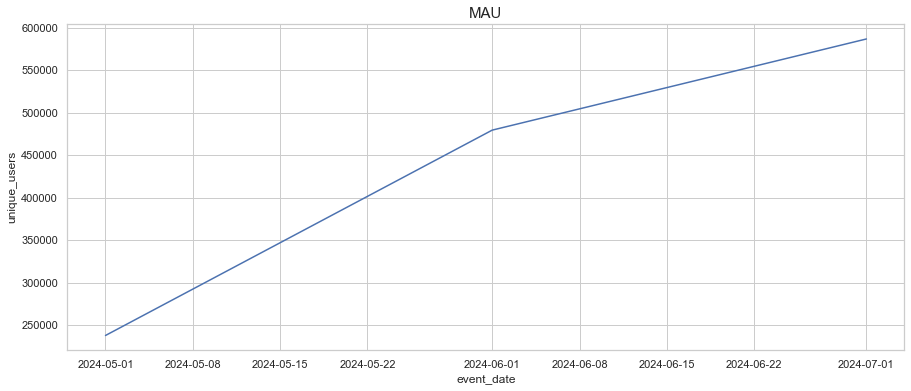

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.title('MAU', fontsize=15)  
sns.lineplot(data=mau_df, x='event_date', y='unique_users')

In [59]:
query = '''
    SELECT toString(start_day) AS start_day,
           toString(day) AS day,
           count(user_id) AS users
       FROM
         (SELECT *
          FROM
            (SELECT user_id,
                    min(toDate(time)) AS start_day
             FROM simulator_20240620.feed_actions
             GROUP BY user_id) t1
          JOIN
            (SELECT DISTINCT user_id,
                             toDate(time) AS day
             FROM simulator_20240620.feed_actions) t2 USING user_id
          )
       WHERE toDate(start_day) >= today() - 30
       GROUP BY start_day,
                day
'''

retention_df = pandahouse.read_clickhouse(connection=connection, query=query)

In [64]:
pivoted_retention = retention_df.pivot(index="day", columns="start_day", values="users")

In [65]:
pivoted_retention = pivoted_retention.divide(pivoted_retention['2024-07-02'], axis=0)

In [66]:
pivoted_retention

start_day,2024-07-02,2024-07-03,2024-07-04,2024-07-05,2024-07-06,2024-07-07,2024-07-08,2024-07-09,2024-07-10,2024-07-11,...,2024-07-23,2024-07-24,2024-07-25,2024-07-26,2024-07-27,2024-07-28,2024-07-29,2024-07-30,2024-07-31,2024-08-01
day,,,,,,,,,,,,,,,,,,,,,
2024-07-02,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-03,1.0,2.346833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-04,1.0,1.199770,1.723307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-05,1.0,1.141892,0.501126,1.520270,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-06,1.0,1.114320,0.499398,0.462094,1.569194,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-07,1.0,1.181326,0.571042,0.434371,0.598106,1.810555,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-08,1.0,1.100264,0.543536,0.440633,0.505277,0.618734,2.084433,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-09,1.0,1.188427,0.572700,0.419881,0.581602,0.646884,0.962908,1.608309,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-10,1.0,1.205047,0.531546,0.432177,0.569401,0.637224,0.968454,0.613565,1.829653,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
retention_df.dtypes

start_day    datetime64[ns]
day          datetime64[ns]
users                uint64
dtype: object

<AxesSubplot:xlabel='start_day', ylabel='day'>

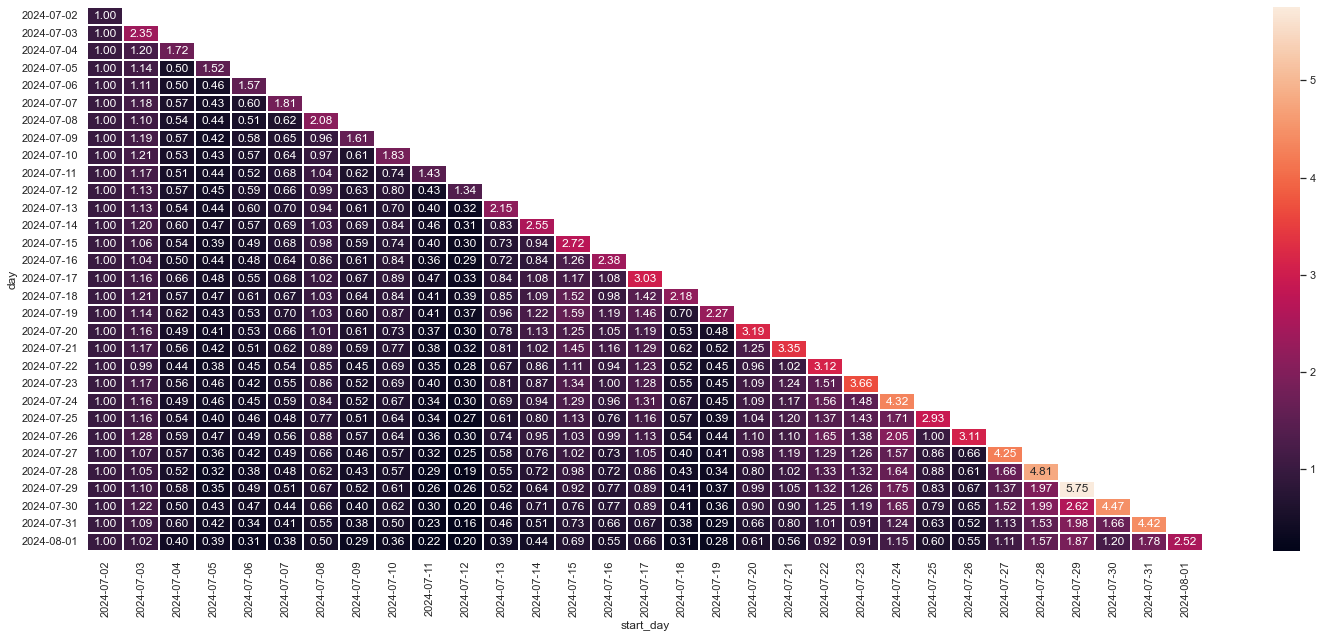

In [70]:
plt.figure(figsize=(25, 10))
sns.heatmap(pivoted_retention, annot=True, fmt='.2f', linewidth=.3)

In [40]:
group_by_country = event_df.groupby(['event_date', 'country'], as_index=False).sum()

<AxesSubplot:xlabel='event_date', ylabel='unique_users'>

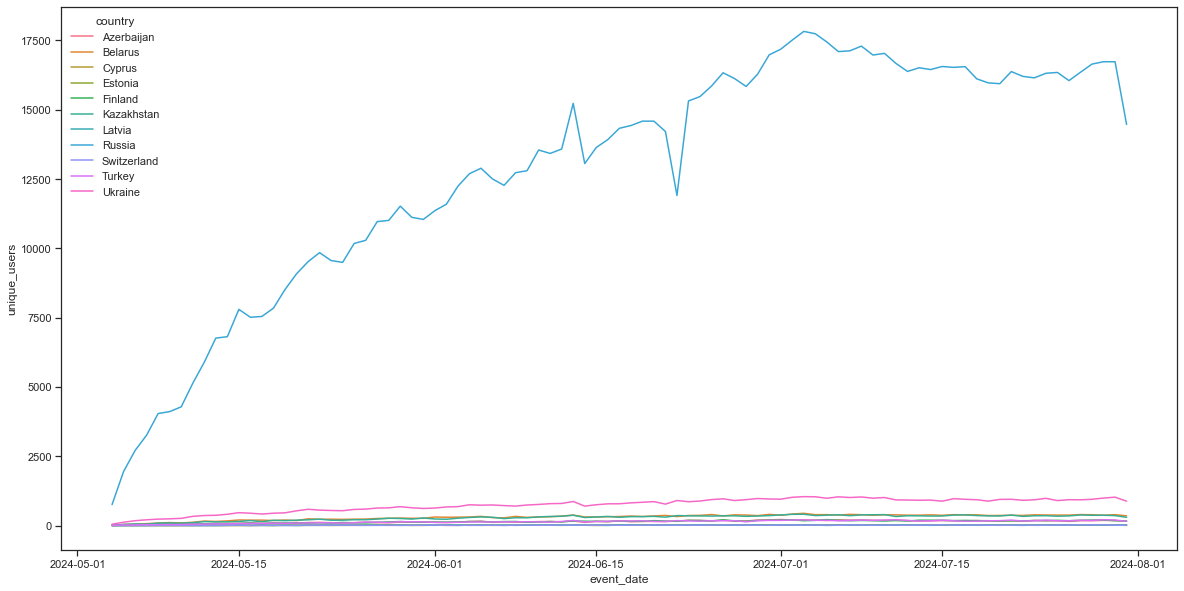

In [41]:
sns.lineplot(data = group_by_country, x='event_date', y='unique_users', hue='country')

In [48]:
top_5_countries = event_df.groupby('country', as_index=False).sum().sort_values('unique_users', ascending=False).head()

In [49]:
top_5_countries

,country,unique_users
7,Russia,1143658
10,Ukraine,66268
1,Belarus,27068
5,Kazakhstan,25371
4,Finland,12704


In [ ]:
message = 'Данные об ленте новостей./nГрафики об количестве лайков, просмотров, и CTR c момента запуска приложения'
bot.sendMessage(chat_id = chat_id, text = message)

In [5]:
query = '''
    SELECT toDate(time) AS event_date,
           countIf(action='view') AS views,
           countIf(action='like') AS likes,
           countIf(action='like')/countIf(action='view') AS CTR
    FROM simulator_20240620.feed_actions
    GROUP BY toDate(time)
'''

df_feed_actions = pandahouse.read_clickhouse(connection=connection, query=query)

<AxesSubplot:xlabel='event_date', ylabel='views'>

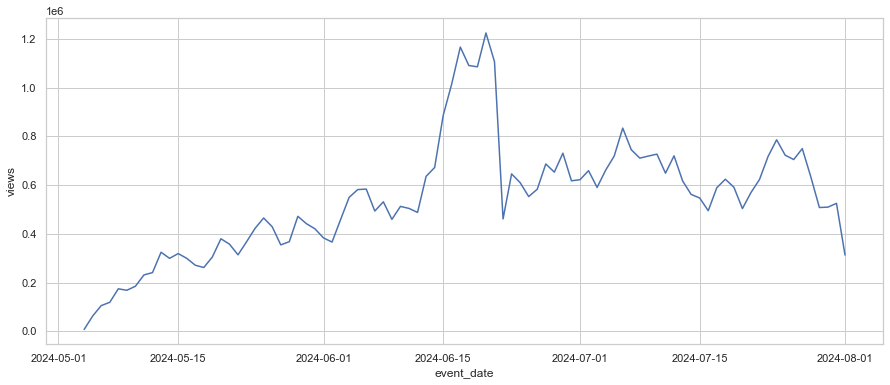

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_feed_actions, x='event_date', y='views')

<AxesSubplot:xlabel='event_date', ylabel='likes'>

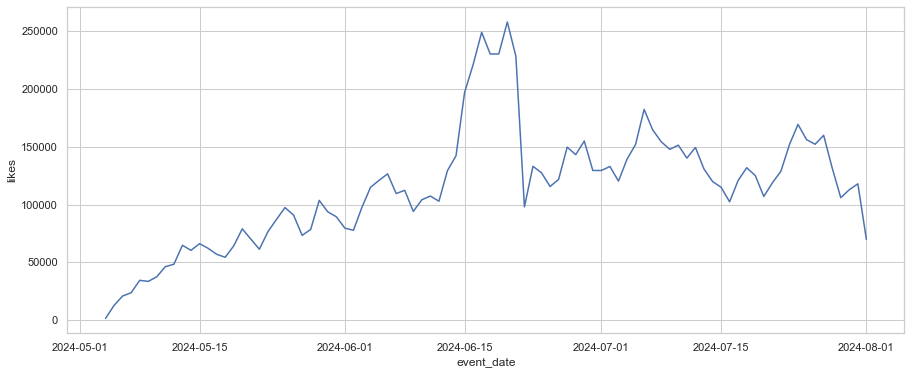

In [9]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_feed_actions, x='event_date', y='likes')

<AxesSubplot:xlabel='event_date', ylabel='CTR'>

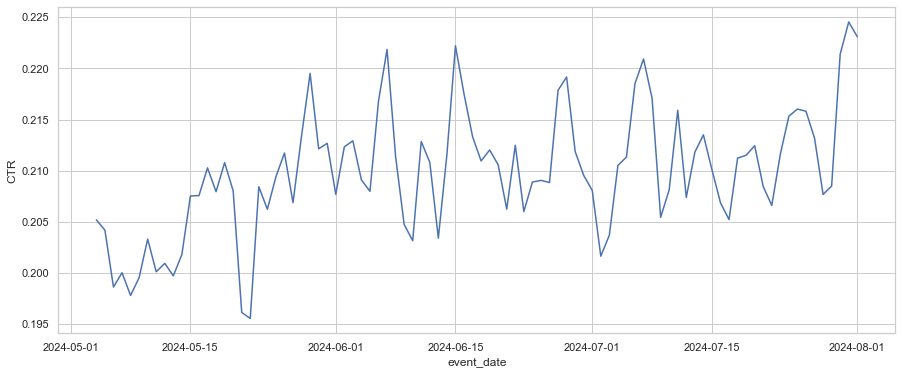

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_feed_actions, x='event_date', y='CTR')

In [ ]:
message = 'Данные об сообщениях./nКоличество людей отправляющих сообщения, распределения по дню '

In [ ]:
SELECT toDate(time) AS event_date,
       user_id,
       receiver_id
FROM simulator_20240620.message_actions

In [12]:
query = '''
    SELECT toDate(time) AS event_date,
           user_id,
           receiver_id
    FROM simulator_20240620.message_actions
'''

df_message_actions = pandahouse.read_clickhouse(connection=connection, query=query)

In [17]:
group_by_date = df_message_actions.groupby('event_date', as_index=False).nunique()

Text(0.5, 1.0, 'Количество пользователей отправляющих сообщение')

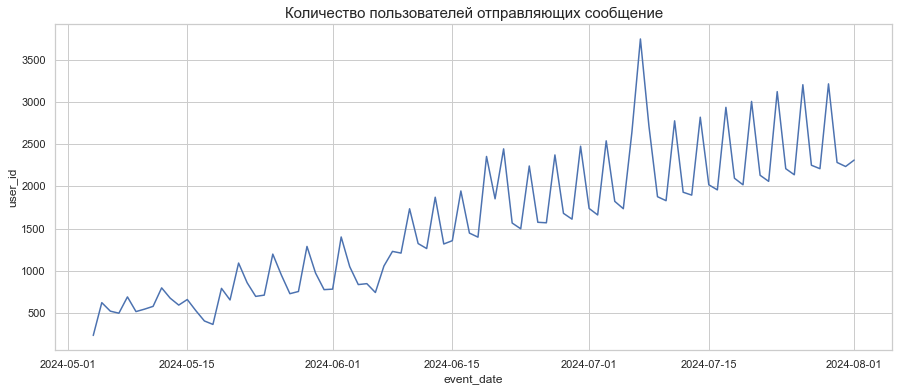

In [21]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=group_by_date, x='event_date', y='user_id')
plt.title('Количество пользователей отправляющих сообщение', fontsize=15)

Text(0.5, 1.0, 'Количество пользователей принимающих сообщение')

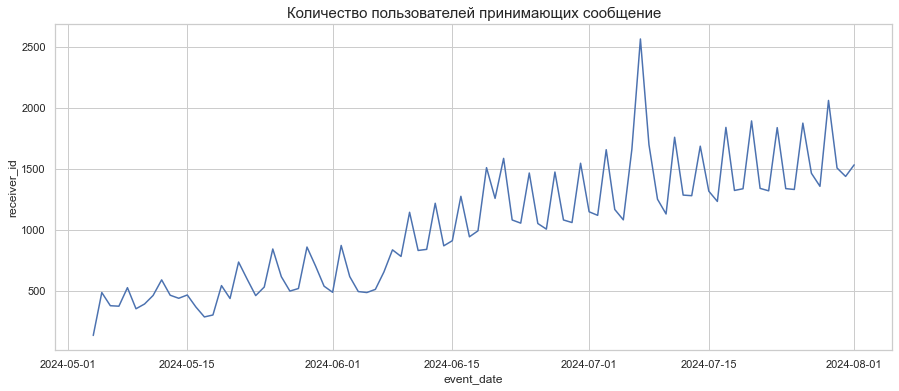

In [22]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=group_by_date, x='event_date', y='receiver_id')
plt.title('Количество пользователей принимающих сообщение', fontsize=15)